<a href="https://colab.research.google.com/github/dauvannam321/Inpainting_Image/blob/main/Inpainting_Image_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model

# **U-NET MODEL**

In [ ]:
class BuildUnet():
    def __init__(self):
        self.down_filters = [64, 128, 256, 512]
        self.up_filters = [512, 256, 128, 64]

    def extract_first_features(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same',
                          kernel_initializer='he_normal', use_bias=False)(inputs)
        x = layers.LeakyReLU()(x)

        return x


    def DoubleConv2D(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                          kernel_initializer='he_normal', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                          kernel_initializer='he_normal', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        return x


    def downsample(self, inputs, filters):
        bdown = self.DoubleConv2D(inputs, filters)
        x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(bdown)

        return x, bdown


    def upsample(self, inputs1, inputs2, filters):
        inputs1 = layers.UpSampling2D(interpolation='bilinear')(inputs1)
        inputs1 = layers.Conv2D(filters=filters, kernel_size=(1,1),
                                kernel_initializer='he_normal', use_bias=False)(inputs1)
        inputs1 = layers.BatchNormalization()(inputs1)
        inputs1 = layers.LeakyReLU()(inputs1)
        x = layers.Concatenate()([inputs1, inputs2])
        x = self.DoubleConv2D(x, filters)

        return x


    def build_model(self, input_shape=(256,256,3)):
        inputs = layers.Input(shape=input_shape)
        x = self.extract_first_features(inputs, filters=64)

        # Downsampling through the model
        skips = []
        for df in self.down_filters:
            x, bdown = self.downsample(x, filters=df)
            skips.append(bdown)

        # Mid
        x = self.DoubleConv2D(x, filters=1024)

        # Upsampling and establishing the skip connections
        skips = reversed(skips)
        for uf, skip in zip(self.up_filters, skips):
            x = self.upsample(x, skip, filters=uf)

        # Final
        outputs = layers.Conv2D(filters=input_shape[-1], kernel_size=(1,1), activation='tanh',
                                      kernel_initializer='he_normal', use_bias=False)(x)

        model = Model(inputs=[inputs], outputs=[outputs])

        return model

# **Prepare Inpainting dataset**

In [ ]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset.git

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (53.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!tree small_dog_cat_dataset

small_dog_cat_dataset
├── test
│   ├── cats
│   │   ├── cat.10028.jpg
│   │   ├── cat.10098.jpg
│   │   ├── cat.10108.jpg
│   │   ├── cat.10132.jpg
│   │   ├── cat.10172.jpg
│   │   ├── cat.10173.jpg
│   │   ├── cat.10196.jpg
│   │   ├── cat.10209.jpg
│   │   ├── cat.10247.jpg
│   │   ├── cat.10304.jpg
│   │   ├── cat.10539.jpg
│   │   ├── cat.10545.jpg
│   │   ├── cat.10592.jpg
│   │   ├── cat.10636.jpg
│   │   ├── cat.10660.jpg
│   │   ├── cat.10708.jpg
│   │   ├── cat.10738.jpg
│   │   ├── cat.1073.jpg
│   │   ├── cat.1075.jpg
│   │   ├── cat.10777.jpg
│   │   ├── cat.10817.jpg
│   │   ├── cat.10871.jpg
│   │   ├── cat.11013.jpg
│   │   ├── cat.11075.jpg
│   │   ├── cat.110.jpg
│   │   ├── cat.11107.jpg
│   │   ├── cat.11113.jpg
│   │   ├── cat.11190.jpg
│   │   ├── cat.11229.jpg
│   │   ├── cat.11272.jpg
│   │   ├── cat.11521.jpg
│   │   ├── cat.11543.jpg
│   │   ├── cat.11552.jpg
│   │   ├── cat.11600.jpg
│   │   ├── cat.11654.jpg
│   │   ├── cat.11665.jpg
│   │   ├── cat.11736.jp

In [ ]:
import numpy as np
import cv2

In [ ]:
LHR_TRAIN_DATA_PATH = '/content/small_dog_cat_dataset/train/dogs' # 1000
LHR_VAL_DATA_PATH = '/content/small_dog_cat_dataset/test/dogs' # 300

BATCH_SIZE  = 8
BUFFER_SIZE = BATCH_SIZE*10
IMG_WIDTH   = 256
IMG_HEIGHT  = 256

def create_mask(image):
    masked_image = tf.identity(image)
    ## Prepare masking matrix
    mask = np.full((IMG_WIDTH,IMG_HEIGHT,3), 0, np.uint8)
    for _ in range(np.random.randint(1, 15)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, IMG_WIDTH), np.random.randint(1, IMG_WIDTH)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, IMG_HEIGHT), np.random.randint(1, IMG_HEIGHT)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 15)
      # Draw black line on the black mask
      cv2.line(mask,(x1,y1),(x2,y2),(255,255,255),thickness)

    # Perforn bitwise and operation to mak the image
#     masked_image = cv2.bitwise_and(img, mask)
    masked_image = tf.bitwise.bitwise_or(masked_image, mask)
    masked_image = tf.convert_to_tensor(masked_image)
    masked_image = tf.cast(masked_image, tf.float32)
    return masked_image

def tf_function(image):
    masked_image = tf.numpy_function(create_mask, [image], tf.float32)
    return masked_image


def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image, [256,256], method='nearest')

    input_image  = tf_function(image)
    target_image = image

    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    return input_image, target_image

In [ ]:
# image = tf.io.read_file(LHR_TRAIN_DATA_PATH+'/dog.10002.jpg')
# image = tf.image.decode_jpeg(image,channels=3)
# print("image", image.shape)
# masked_image = tf.identity(image)
# masked_image = tf.image.resize(masked_image, [256,256], method='nearest')
# print("masked_image: ", masked_image.shape)
# mask = np.full((IMG_WIDTH,IMG_HEIGHT,3), 0, np.uint8)
# for _ in range(np.random.randint(1, 15)):
#   # Get random x locations to start line
#   x1, x2 = np.random.randint(1, IMG_WIDTH), np.random.randint(1, IMG_WIDTH)
#   # Get random y locations to start line
#   y1, y2 = np.random.randint(1, IMG_HEIGHT), np.random.randint(1, IMG_HEIGHT)
#   # Get random thickness of the line drawn
#   thickness = np.random.randint(1, 15)
#   # Draw black line on the black mask
#   cv2.line(mask,(x1,y1),(x2,y2),(255,255,255),thickness)
# masked_image = tf.bitwise.bitwise_or(masked_image, mask)
# masked_image = tf.convert_to_tensor(masked_image)
# masked_image = tf.cast(masked_image, tf.float32)
# plt.imshow(masked_image)

(256, 256, 3)
(256, 256, 3)


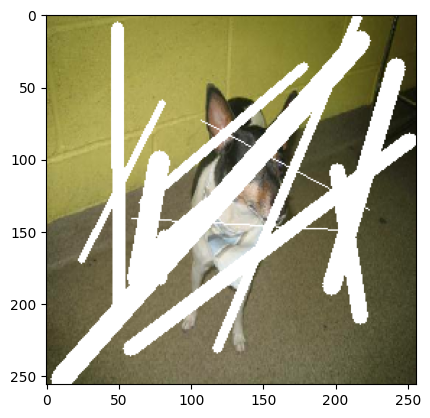

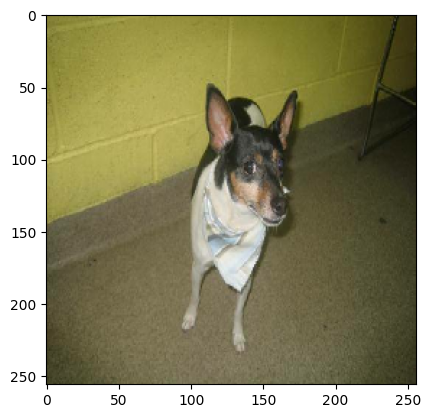

In [ ]:
input_image, target_image = load(LHR_TRAIN_DATA_PATH+'/dog.10002.jpg')
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image/255.0)
plt.figure()
plt.imshow(target_image/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_image, target_image):
    input_image  = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    return input_image, target_image


def load_image_train(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = normalize(input_image, target_image)

    return input_image, target_image

def load_image_test(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = normalize(input_image, target_image)

    return input_image, target_image

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(LHR_TRAIN_DATA_PATH + '/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(LHR_VAL_DATA_PATH + '/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
def generator_loss(fake, target):
    l1_loss = tf.reduce_mean(tf.abs(fake-target))

    return l1_loss

def evaluate(model, epoch):
    psnr_mean = 0.0
    count = 0
    for inputs, targets in test_dataset:
        fake = model([inputs], training=True)

        psnr = tf.image.psnr(fake*0.5 + 0.5, targets*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        # psnr_mean = psnr_mean_l

        psnr_mean += __psnr_mean
        count =count + 1

    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)

    return psnr_mean

def generate_images(model, inputs, targets):
    fake = model([inputs], training=True)
    plt.figure(figsize=(15,20))

    display_list = [inputs[0], targets[0], fake[0]]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# **Train**

In [ ]:
build_unet = BuildUnet()
unet_model = build_unet.build_model()

# image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
# x = tf.keras.layers.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH)(image_input)
# x = unet_model(x)
# Inp_unet_model= Model(inputs=image_input, outputs=x)
Inp_unet_model = unet_model
Inp_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  192         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # output
        fake = Inp_unet_model([inputs], training=True)
        loss = generator_loss(fake, targets)


    generator_gradients = tape.gradient(loss, Inp_unet_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, Inp_unet_model.trainable_variables))

    return loss



def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for inputs, targets in train_ds:
            loss = train_step(inputs, targets)
            total_loss = total_loss + loss
        total_loss = total_loss/400
        print('epoch: {}   loss: {}'.format(epoch, total_loss))

        pnsr = evaluate(Inp_unet_model, epoch)
        if best_pnsr < pnsr:
            best_pnsr = pnsr

        if epoch % 10 == 0:
            for inputs, targets in test_ds.take(1):
                generate_images(Inp_unet_model, inputs, targets)


epoch: 0   loss: 0.4438438415527344
-------- psnr:  21.030958    ----- epoch:  0   count:  300


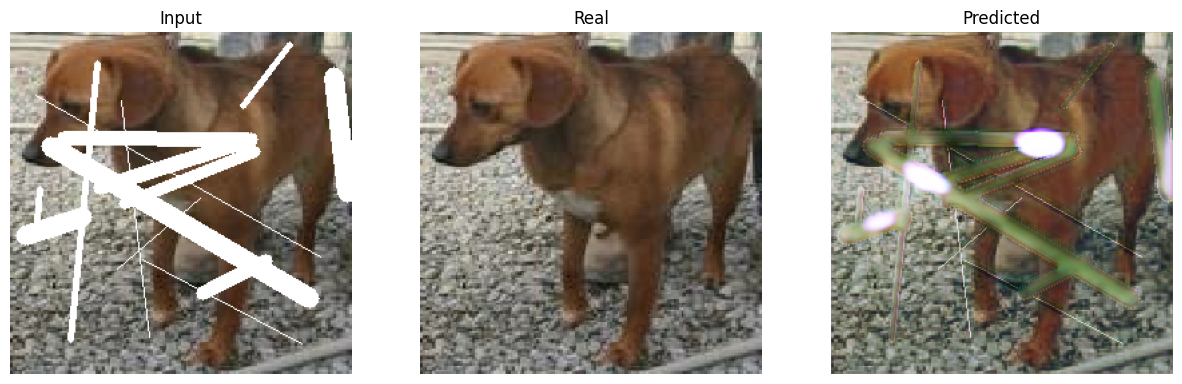

epoch: 1   loss: 0.30193522572517395
-------- psnr:  21.98245    ----- epoch:  1   count:  300
epoch: 2   loss: 0.2568056583404541
-------- psnr:  22.211254    ----- epoch:  2   count:  300
epoch: 3   loss: 0.23681867122650146
-------- psnr:  23.578646    ----- epoch:  3   count:  300
epoch: 4   loss: 0.21492667496204376
-------- psnr:  23.903135    ----- epoch:  4   count:  300
epoch: 5   loss: 0.2116776406764984
-------- psnr:  24.264986    ----- epoch:  5   count:  300
epoch: 6   loss: 0.193698450922966
-------- psnr:  24.28522    ----- epoch:  6   count:  300
epoch: 7   loss: 0.18894946575164795
-------- psnr:  24.650381    ----- epoch:  7   count:  300
epoch: 8   loss: 0.177588552236557
-------- psnr:  25.373163    ----- epoch:  8   count:  300
epoch: 9   loss: 0.17331206798553467
-------- psnr:  25.352571    ----- epoch:  9   count:  300
epoch: 10   loss: 0.16634422540664673
-------- psnr:  24.298523    ----- epoch:  10   count:  300


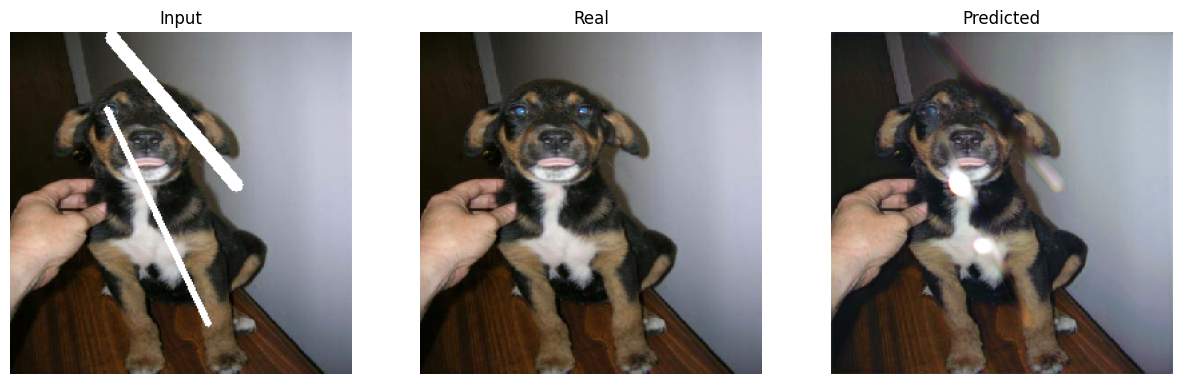

epoch: 11   loss: 0.16439193487167358
-------- psnr:  25.706297    ----- epoch:  11   count:  300
epoch: 12   loss: 0.15961913764476776
-------- psnr:  25.951569    ----- epoch:  12   count:  300
epoch: 13   loss: 0.156398206949234
-------- psnr:  26.246387    ----- epoch:  13   count:  300
epoch: 14   loss: 0.15285521745681763
-------- psnr:  26.06334    ----- epoch:  14   count:  300
epoch: 15   loss: 0.15248392522335052
-------- psnr:  25.738346    ----- epoch:  15   count:  300
epoch: 16   loss: 0.14548832178115845
-------- psnr:  26.58683    ----- epoch:  16   count:  300
epoch: 17   loss: 0.1448248028755188
-------- psnr:  26.286163    ----- epoch:  17   count:  300
epoch: 18   loss: 0.1414855420589447
-------- psnr:  26.50305    ----- epoch:  18   count:  300
epoch: 19   loss: 0.13913020491600037
-------- psnr:  26.65943    ----- epoch:  19   count:  300
epoch: 20   loss: 0.13701362907886505
-------- psnr:  26.846336    ----- epoch:  20   count:  300


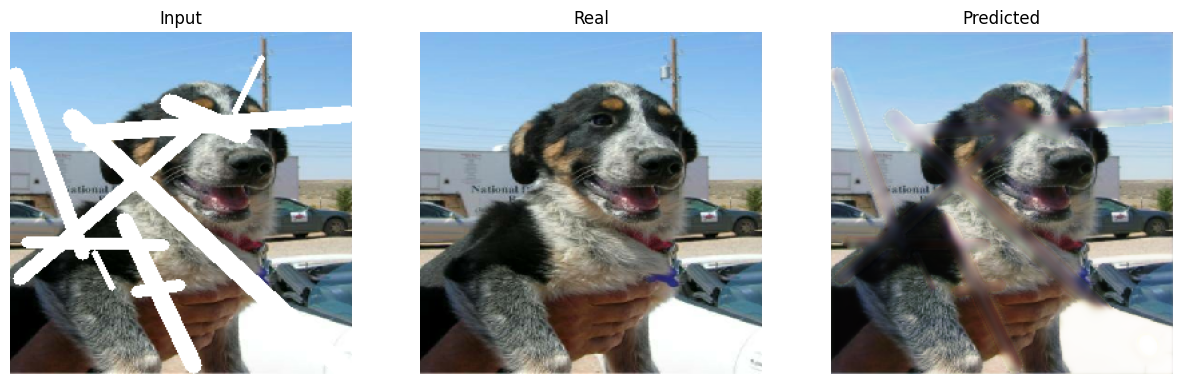

epoch: 21   loss: 0.13458552956581116
-------- psnr:  26.747755    ----- epoch:  21   count:  300
epoch: 22   loss: 0.13230711221694946
-------- psnr:  25.783045    ----- epoch:  22   count:  300
epoch: 23   loss: 0.13146895170211792
-------- psnr:  26.488722    ----- epoch:  23   count:  300
epoch: 24   loss: 0.13114528357982635
-------- psnr:  26.862823    ----- epoch:  24   count:  300
epoch: 25   loss: 0.12929464876651764
-------- psnr:  26.809504    ----- epoch:  25   count:  300
epoch: 26   loss: 0.1289164125919342
-------- psnr:  27.104097    ----- epoch:  26   count:  300
epoch: 27   loss: 0.12467607855796814
-------- psnr:  27.456478    ----- epoch:  27   count:  300
epoch: 28   loss: 0.12619023025035858
-------- psnr:  27.318235    ----- epoch:  28   count:  300
epoch: 29   loss: 0.12560413777828217
-------- psnr:  27.178205    ----- epoch:  29   count:  300
epoch: 30   loss: 0.12244892865419388
-------- psnr:  27.395098    ----- epoch:  30   count:  300


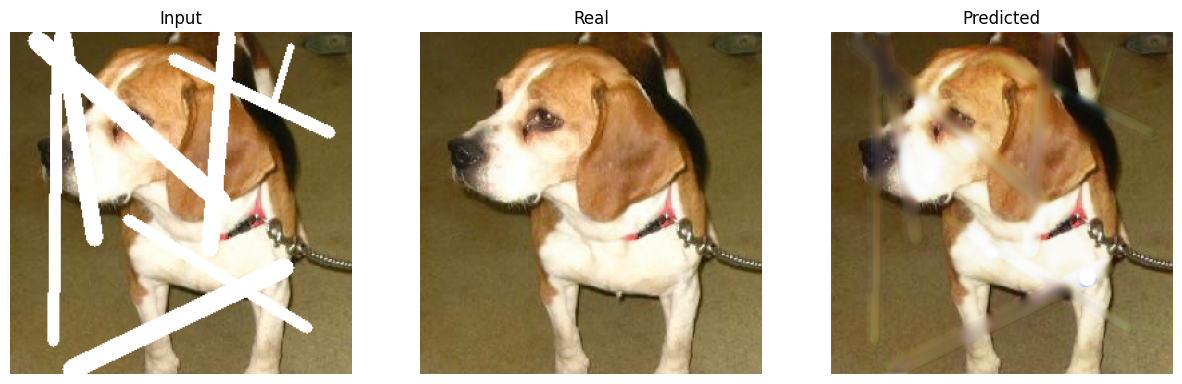

epoch: 31   loss: 0.12187187373638153
-------- psnr:  27.40582    ----- epoch:  31   count:  300
epoch: 32   loss: 0.12077575922012329
-------- psnr:  27.39319    ----- epoch:  32   count:  300
epoch: 33   loss: 0.11993395537137985
-------- psnr:  27.39432    ----- epoch:  33   count:  300
epoch: 34   loss: 0.11933983117341995
-------- psnr:  27.806425    ----- epoch:  34   count:  300
epoch: 35   loss: 0.11570306122303009
-------- psnr:  27.354866    ----- epoch:  35   count:  300
epoch: 36   loss: 0.11653856188058853
-------- psnr:  27.752308    ----- epoch:  36   count:  300
epoch: 37   loss: 0.1172914132475853
-------- psnr:  27.813814    ----- epoch:  37   count:  300
epoch: 38   loss: 0.11500321328639984
-------- psnr:  27.140053    ----- epoch:  38   count:  300
epoch: 39   loss: 0.11346356570720673
-------- psnr:  27.806911    ----- epoch:  39   count:  300
epoch: 40   loss: 0.11384003609418869
-------- psnr:  27.68986    ----- epoch:  40   count:  300


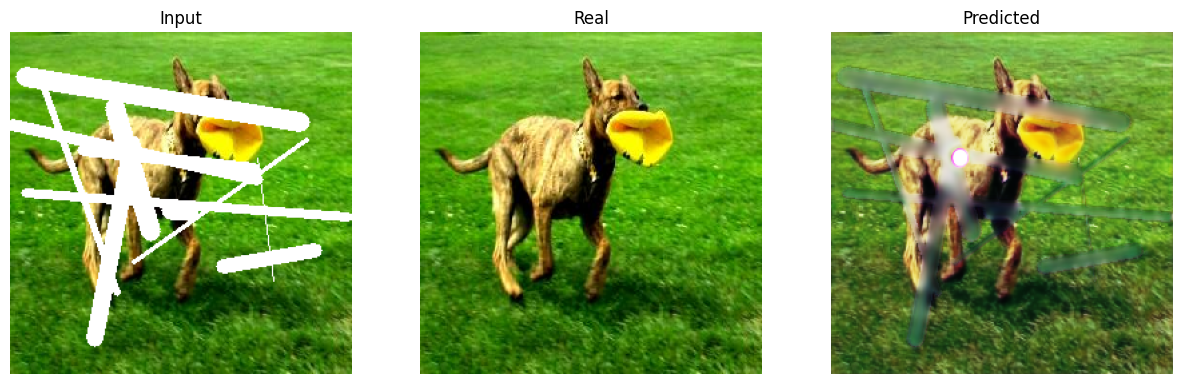

epoch: 41   loss: 0.11245625466108322
-------- psnr:  27.208252    ----- epoch:  41   count:  300
epoch: 42   loss: 0.1100761666893959
-------- psnr:  27.98808    ----- epoch:  42   count:  300
epoch: 43   loss: 0.11232896149158478
-------- psnr:  27.757462    ----- epoch:  43   count:  300
epoch: 44   loss: 0.11112935841083527
-------- psnr:  27.82448    ----- epoch:  44   count:  300
epoch: 45   loss: 0.10918042808771133
-------- psnr:  27.59755    ----- epoch:  45   count:  300
epoch: 46   loss: 0.1093325987458229
-------- psnr:  27.831263    ----- epoch:  46   count:  300
epoch: 47   loss: 0.10988235473632812
-------- psnr:  27.516413    ----- epoch:  47   count:  300
epoch: 48   loss: 0.10778065025806427
-------- psnr:  27.602425    ----- epoch:  48   count:  300
epoch: 49   loss: 0.10929692536592484
-------- psnr:  27.999916    ----- epoch:  49   count:  300
epoch: 50   loss: 0.10765444487333298
-------- psnr:  28.306448    ----- epoch:  50   count:  300


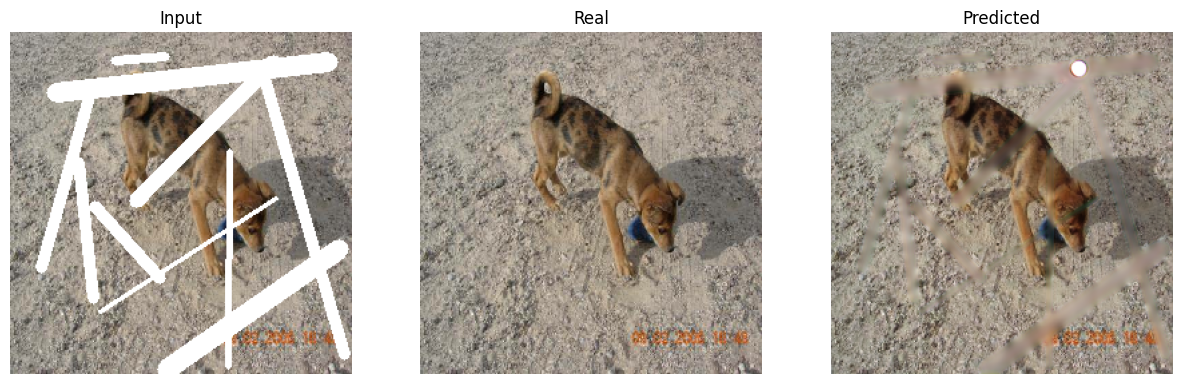

epoch: 51   loss: 0.10510557144880295
-------- psnr:  28.159737    ----- epoch:  51   count:  300
epoch: 52   loss: 0.10438577830791473
-------- psnr:  27.999453    ----- epoch:  52   count:  300
epoch: 53   loss: 0.10685836523771286
-------- psnr:  28.374678    ----- epoch:  53   count:  300
epoch: 54   loss: 0.10437509417533875
-------- psnr:  28.284954    ----- epoch:  54   count:  300
epoch: 55   loss: 0.10401603579521179
-------- psnr:  28.48524    ----- epoch:  55   count:  300
epoch: 56   loss: 0.1054130345582962
-------- psnr:  28.552988    ----- epoch:  56   count:  300
epoch: 57   loss: 0.10498373955488205
-------- psnr:  27.878574    ----- epoch:  57   count:  300
epoch: 58   loss: 0.1034991517663002
-------- psnr:  28.38115    ----- epoch:  58   count:  300
epoch: 59   loss: 0.10435841232538223
-------- psnr:  27.824968    ----- epoch:  59   count:  300
epoch: 60   loss: 0.10298573225736618
-------- psnr:  28.373047    ----- epoch:  60   count:  300


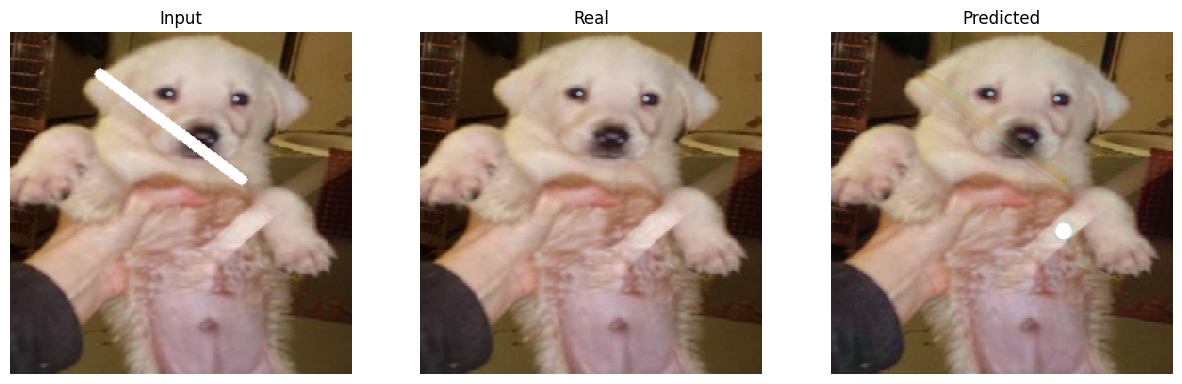

epoch: 61   loss: 0.10117904841899872
-------- psnr:  28.35137    ----- epoch:  61   count:  300
epoch: 62   loss: 0.10064568370580673
-------- psnr:  27.722357    ----- epoch:  62   count:  300
epoch: 63   loss: 0.09988618642091751
-------- psnr:  28.756208    ----- epoch:  63   count:  300
epoch: 64   loss: 0.10231906920671463
-------- psnr:  27.998737    ----- epoch:  64   count:  300
epoch: 65   loss: 0.10131656378507614
-------- psnr:  28.37833    ----- epoch:  65   count:  300
epoch: 66   loss: 0.09799285233020782
-------- psnr:  28.1768    ----- epoch:  66   count:  300
epoch: 67   loss: 0.09929154068231583
-------- psnr:  28.864388    ----- epoch:  67   count:  300
epoch: 68   loss: 0.0993567481637001
-------- psnr:  27.927452    ----- epoch:  68   count:  300
epoch: 69   loss: 0.09904182702302933
-------- psnr:  26.676487    ----- epoch:  69   count:  300
epoch: 70   loss: 0.1006564125418663
-------- psnr:  28.464428    ----- epoch:  70   count:  300


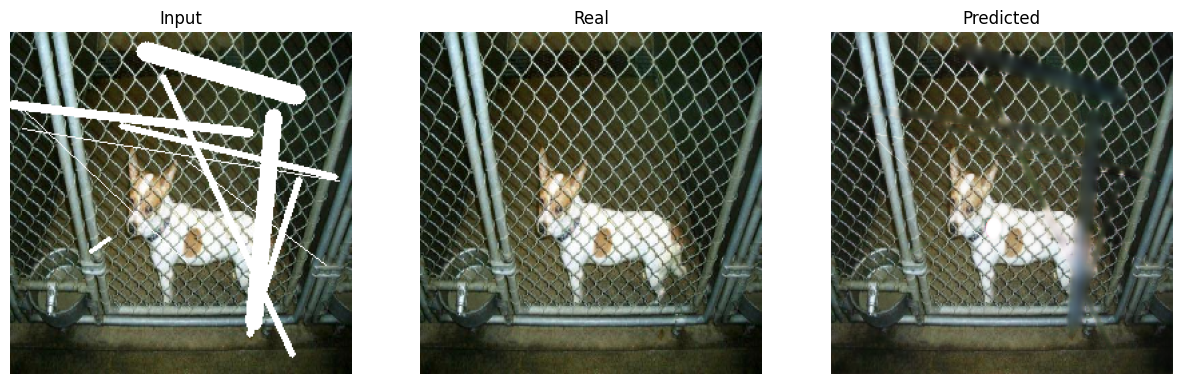

epoch: 71   loss: 0.09713814407587051
-------- psnr:  28.307936    ----- epoch:  71   count:  300
epoch: 72   loss: 0.09715809673070908
-------- psnr:  28.879827    ----- epoch:  72   count:  300
epoch: 73   loss: 0.09775576740503311
-------- psnr:  28.725403    ----- epoch:  73   count:  300
epoch: 74   loss: 0.0954476073384285
-------- psnr:  28.401495    ----- epoch:  74   count:  300
epoch: 75   loss: 0.09671685844659805
-------- psnr:  27.848772    ----- epoch:  75   count:  300
epoch: 76   loss: 0.09692375361919403
-------- psnr:  27.90223    ----- epoch:  76   count:  300
epoch: 77   loss: 0.10040801763534546
-------- psnr:  28.19135    ----- epoch:  77   count:  300
epoch: 78   loss: 0.09628364443778992
-------- psnr:  28.532454    ----- epoch:  78   count:  300
epoch: 79   loss: 0.09550321847200394
-------- psnr:  28.78247    ----- epoch:  79   count:  300
epoch: 80   loss: 0.09520037472248077
-------- psnr:  28.329515    ----- epoch:  80   count:  300


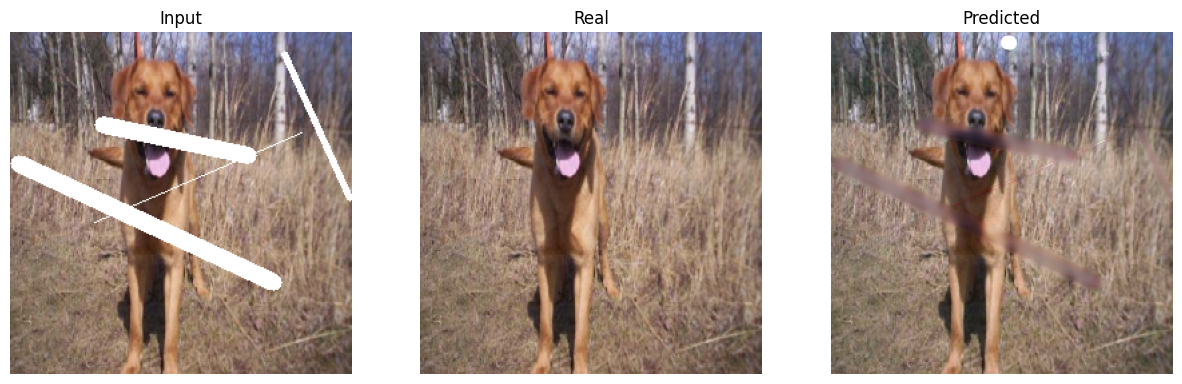

epoch: 81   loss: 0.09655856341123581
-------- psnr:  28.373419    ----- epoch:  81   count:  300
epoch: 82   loss: 0.09498637169599533
-------- psnr:  28.735016    ----- epoch:  82   count:  300
epoch: 83   loss: 0.09566941112279892
-------- psnr:  28.635725    ----- epoch:  83   count:  300
epoch: 84   loss: 0.09336641430854797
-------- psnr:  28.932045    ----- epoch:  84   count:  300
epoch: 85   loss: 0.09369976818561554
-------- psnr:  28.612701    ----- epoch:  85   count:  300
epoch: 86   loss: 0.09308845549821854
-------- psnr:  28.381426    ----- epoch:  86   count:  300
epoch: 87   loss: 0.09979888051748276
-------- psnr:  27.780067    ----- epoch:  87   count:  300
epoch: 88   loss: 0.09575112164020538
-------- psnr:  28.370079    ----- epoch:  88   count:  300
epoch: 89   loss: 0.09178182482719421
-------- psnr:  28.534216    ----- epoch:  89   count:  300
epoch: 90   loss: 0.09224946051836014
-------- psnr:  29.184853    ----- epoch:  90   count:  300


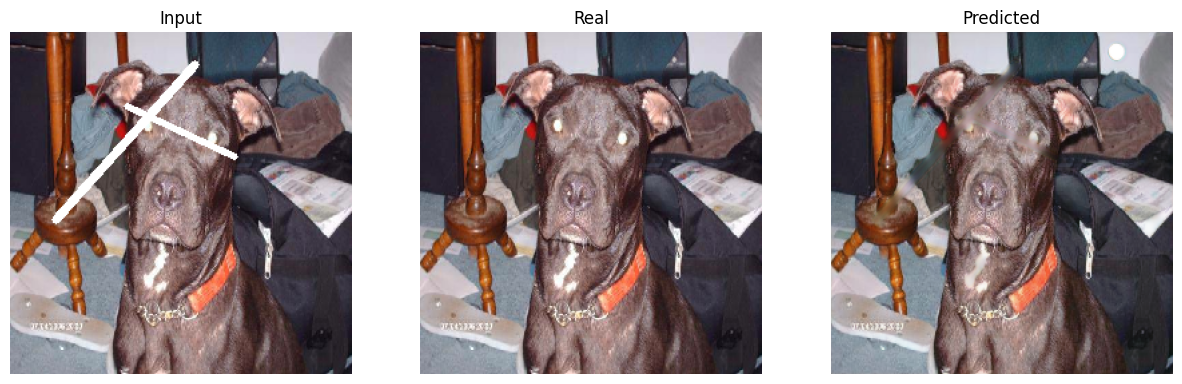

epoch: 91   loss: 0.09158164262771606
-------- psnr:  28.854479    ----- epoch:  91   count:  300
epoch: 92   loss: 0.09178904443979263
-------- psnr:  28.869606    ----- epoch:  92   count:  300
epoch: 93   loss: 0.09169710427522659
-------- psnr:  28.824099    ----- epoch:  93   count:  300
epoch: 94   loss: 0.0925704687833786
-------- psnr:  28.888708    ----- epoch:  94   count:  300
epoch: 95   loss: 0.09109583497047424
-------- psnr:  29.00195    ----- epoch:  95   count:  300
epoch: 96   loss: 0.08975934982299805
-------- psnr:  29.044489    ----- epoch:  96   count:  300
epoch: 97   loss: 0.0912899598479271
-------- psnr:  29.008154    ----- epoch:  97   count:  300
epoch: 98   loss: 0.09038577228784561
-------- psnr:  28.739138    ----- epoch:  98   count:  300
epoch: 99   loss: 0.09274472296237946
-------- psnr:  28.933655    ----- epoch:  99   count:  300


In [ ]:
EPOCHS = 100
fit(train_dataset, EPOCHS, test_dataset)

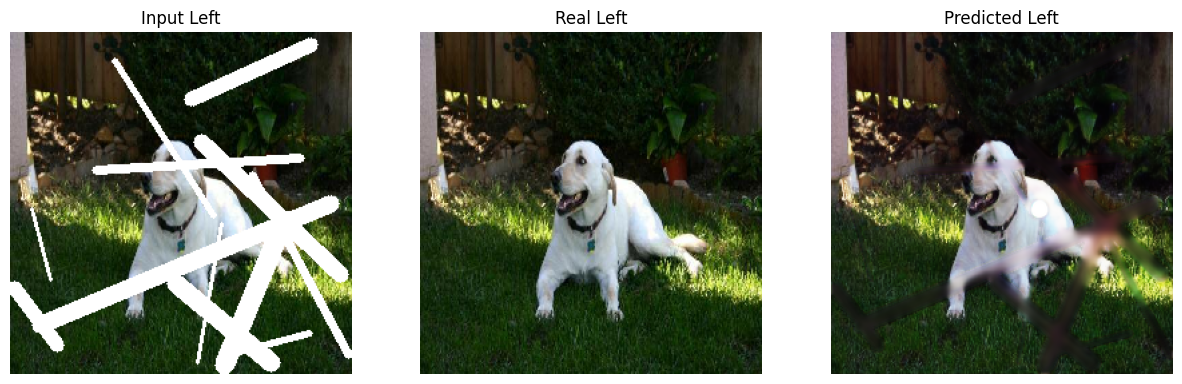

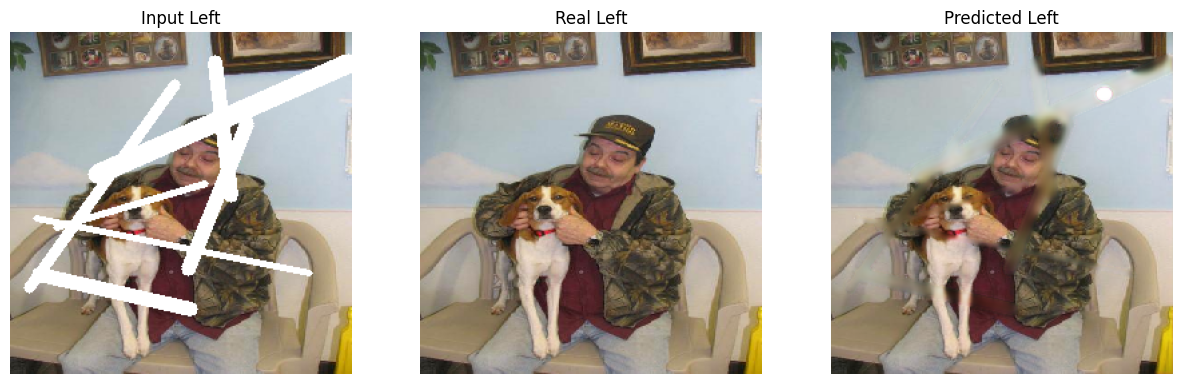

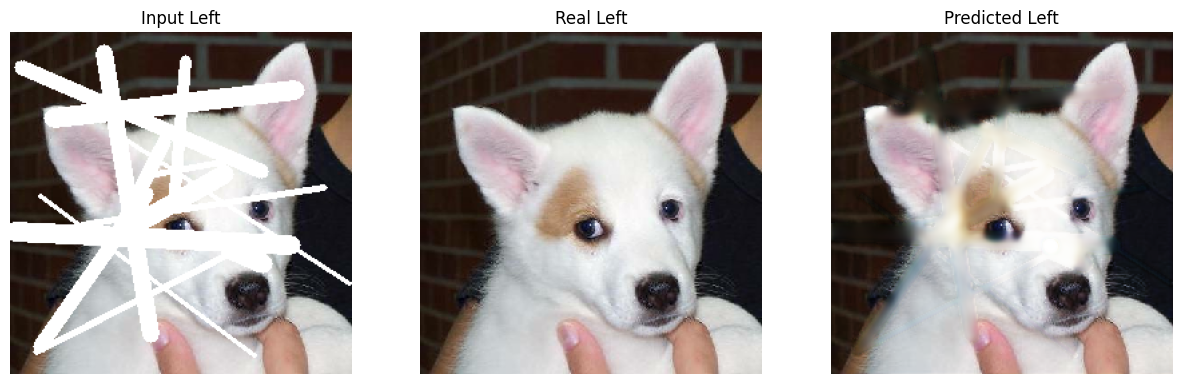

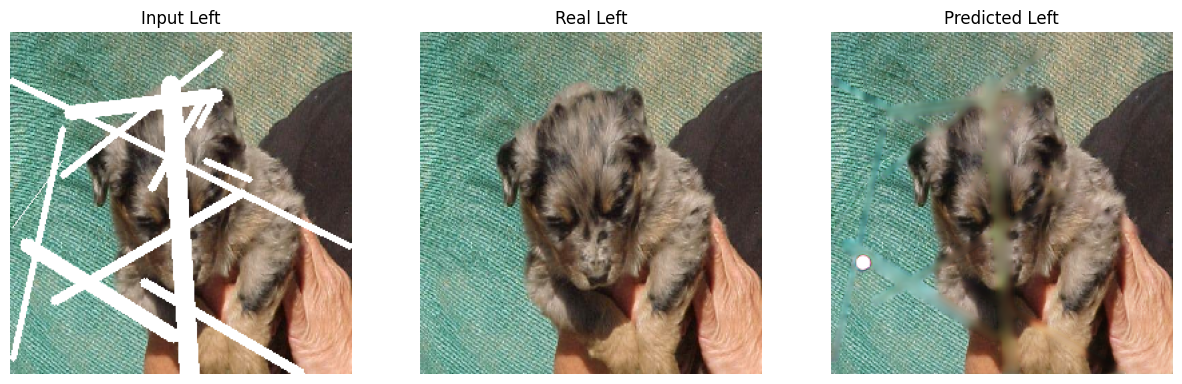

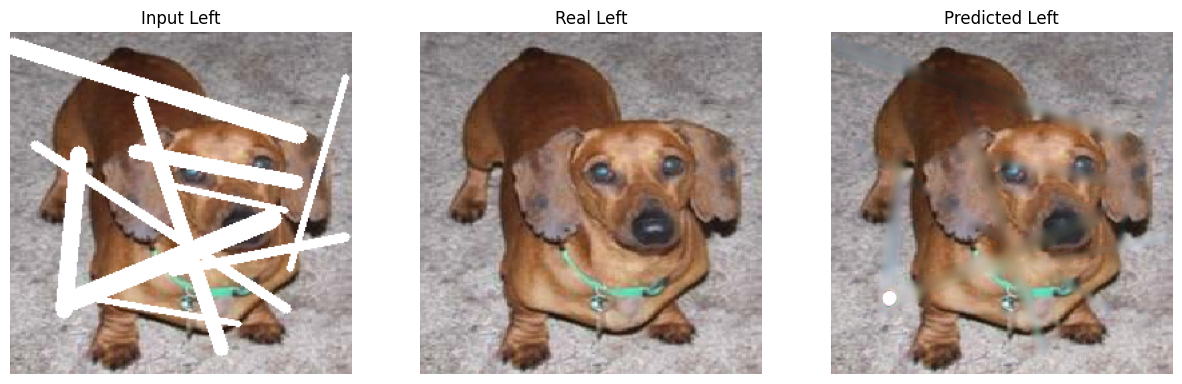

In [ ]:
for _ in range(5):
    for inputs, targets in test_dataset.take(1):
        fake = Inp_unet_model([inputs], training=True)
        plt.figure(figsize=(15,20))

        display_list = [inputs[0], targets[0], fake[0]]
        title = ['Input Left', 'Real Left', 'Predicted Left']


        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()